## Carvana Challenge EDA

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')

Add required imports

In [2]:
from dataset import DatasetHandler
import pandas as pd
import os

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download the dataset

In [3]:
train_data, test_data, metadata_csv, train_masks_csv, train_masks_data = DatasetHandler().download_dataset()

All datasets are present.


Show csv data informations:

In [4]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [5]:
metadata_df.head()

id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA6                  i Sport
3  000f19f6e7d4  2016.0  Chevrolet  Camaro  Camaro                       SS
4  00144e887ae9  2015.0      Acura     TLX     TLX  SH-AWD V6 w/Advance Pkg

In [6]:
train_masks_df.head()

img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...

Count train/test data:

In [7]:
train_files = os.listdir(train_data)
test_files = os.listdir(test_data)
train_masks_files = os.listdir(train_masks_data)
print("Train files count: {}\nTrain masks files count: {}\nTest files count: {}"
      .format(len(train_files), len(train_masks_files), len(test_files)))

Train files count: 5088
Train masks files count: 5088
Test files count: 100064


Get unique ids (each car has 16 images from different angles):

In [8]:
train_ids = list(set(t.split("_")[0] for t in train_files))
masks_ids = list(set(t.split("_")[0] for t in train_masks_files))
test_ids = list(set(t.split("_")[0] for t in test_files))

print("Train files unique ids count: {}\nTest files unique ids count: {}".format(len(train_ids), len(test_ids)))
assert len(train_ids) * 16 == len(train_files)
assert len(test_ids) * 16 == len(test_files)

Train files unique ids count: 318
Test files unique ids count: 6254


## Utility functions

Create a function to get car images path from their ID and another one to open the image and return a numpy matrix.

In [9]:
def get_car_image_files(car_image_id, get_mask=False):
    if get_mask:
        if car_image_id in masks_ids:
            return [train_masks_data + "/" + s for s in train_masks_files if car_image_id in s]
        else:
            raise Exception("No mask with this ID found")
    elif car_image_id in train_ids:
        return [train_data + "/" + s for s in train_files if car_image_id in s]
    elif car_image_id in test_ids:
        return [test_data + "/" + s for s in test_files if car_image_id in s]
    raise Exception("No image with this ID found")
    
def get_image_matrix(image_path):
    img = Image.open(image_path)
    return np.asarray(img, dtype=np.uint8)

## Display a single car with its mask

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


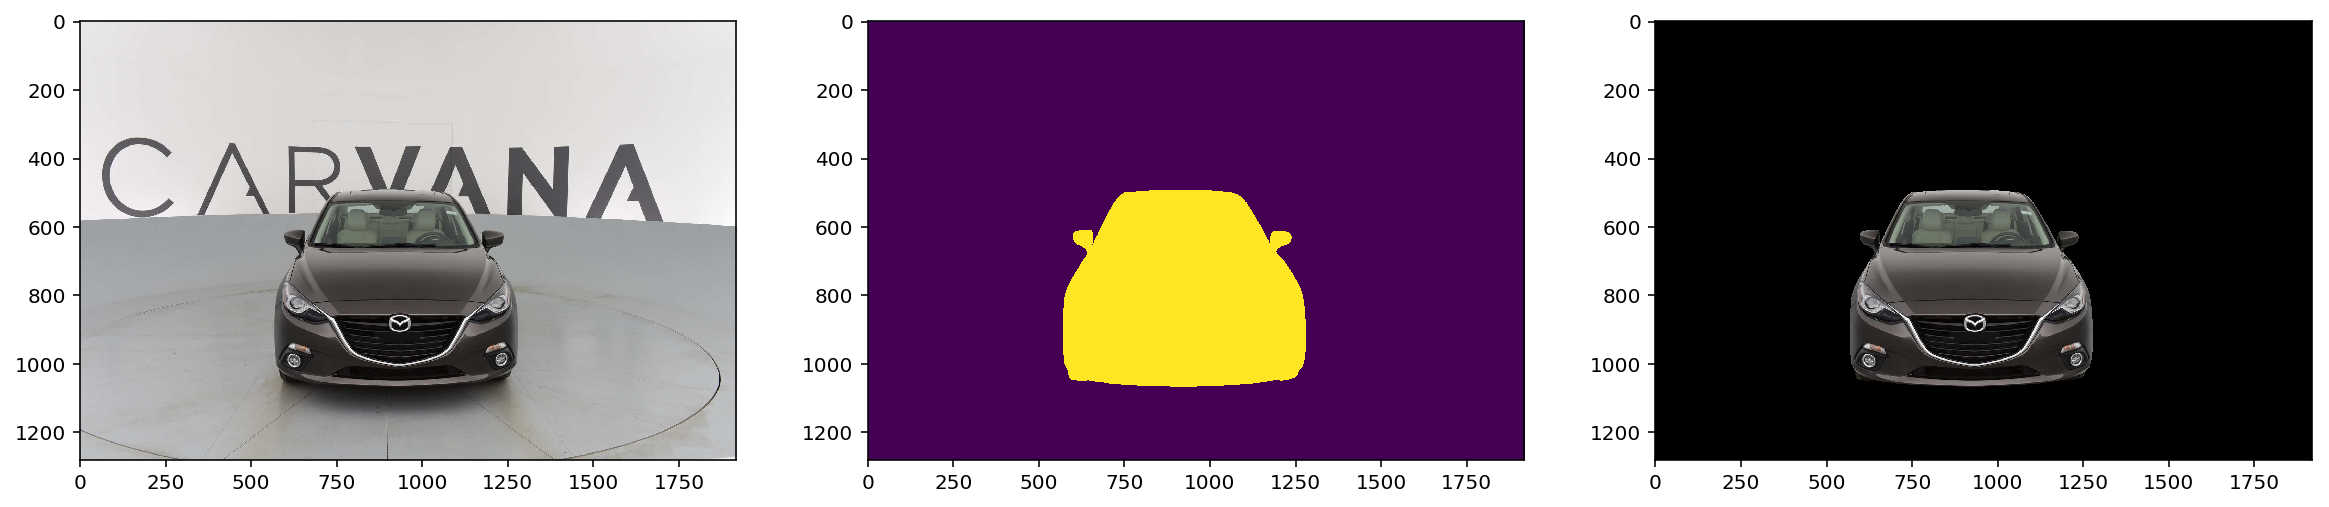

In [10]:
image_id = train_ids[0]

plt.figure(figsize=(20, 20))
img = get_image_matrix(get_car_image_files(image_id)[0])
mask = get_image_matrix(get_car_image_files(image_id, True)[0])
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}"
      .format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked);

## Check train mask DataFrame
Check that the retrived mask indices corresponds to the ones in the csv file by checking the rle signatures

In [11]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

file_name = get_car_image_files(image_id)[0].split("/")[-1]
mask_rle = train_masks_df[train_masks_df['img'] == file_name]["rle_mask"].iloc[0]
assert rle_to_string(rle_encode(mask)) == mask_rle, "Mask rle don't match"
print("Mask rle match!")

Mask rle match!


## Display few random cars from train dataset

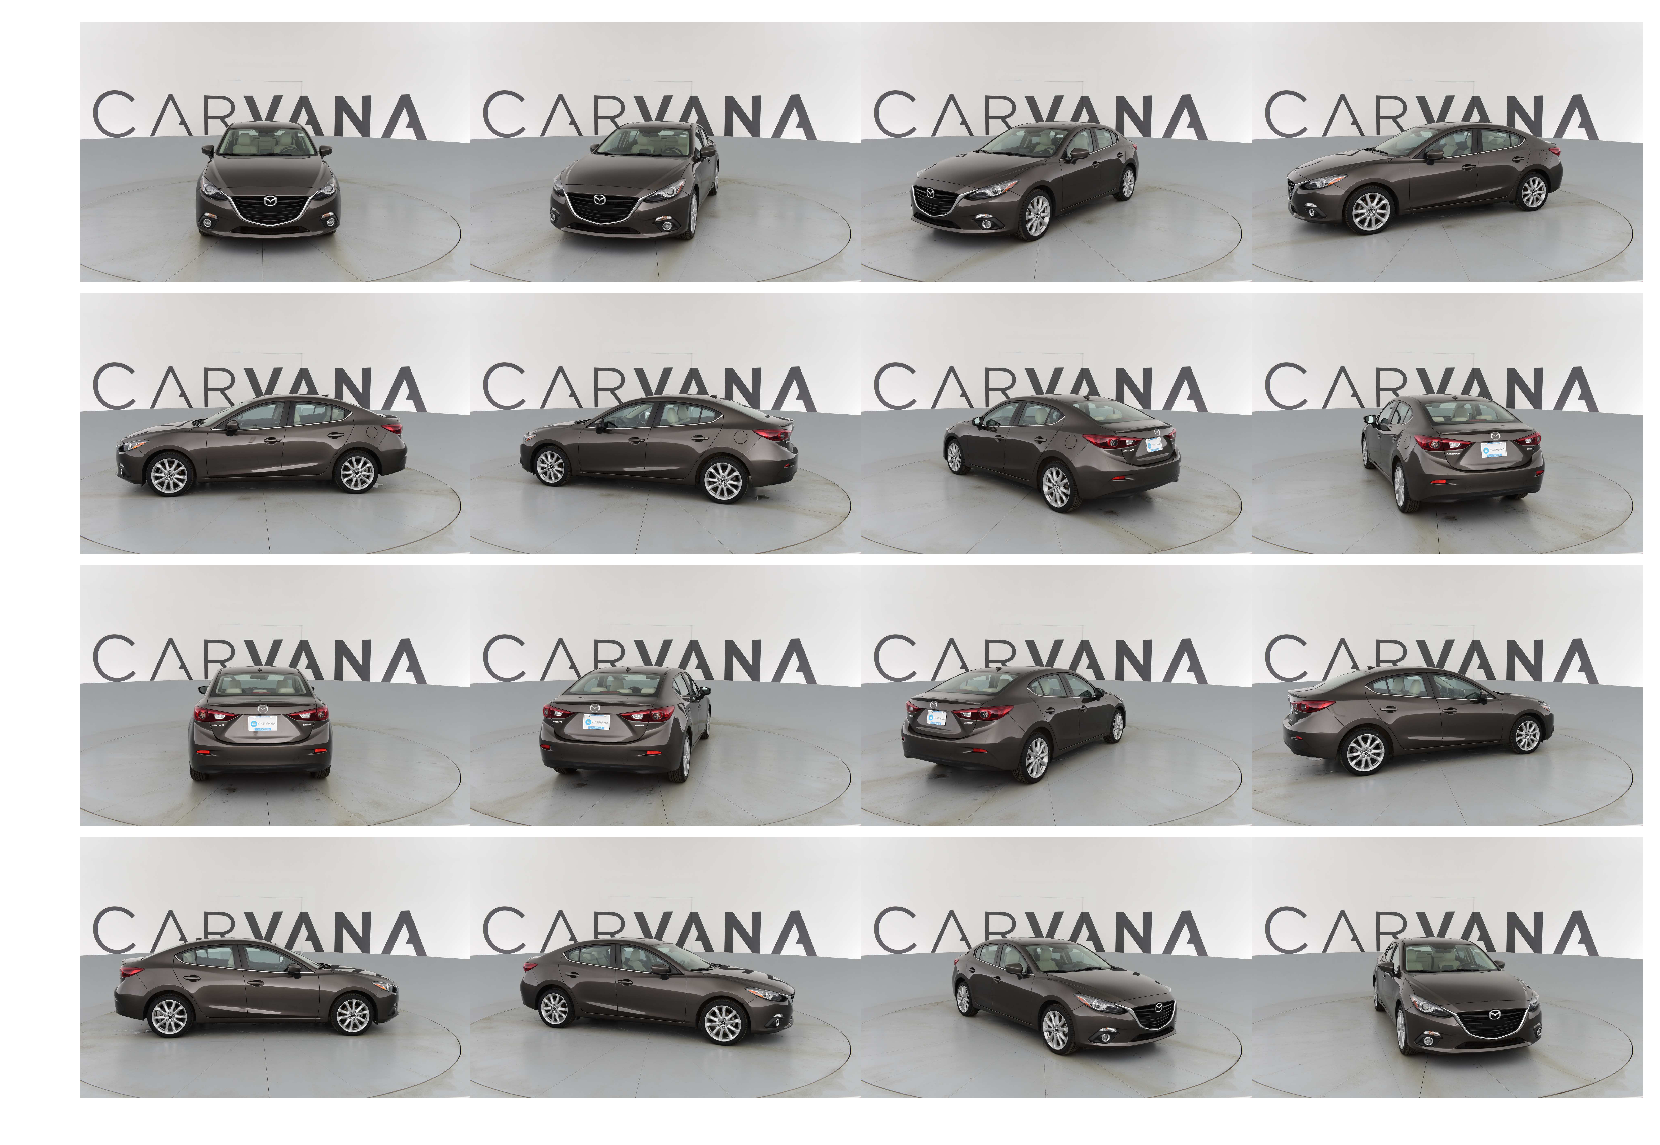

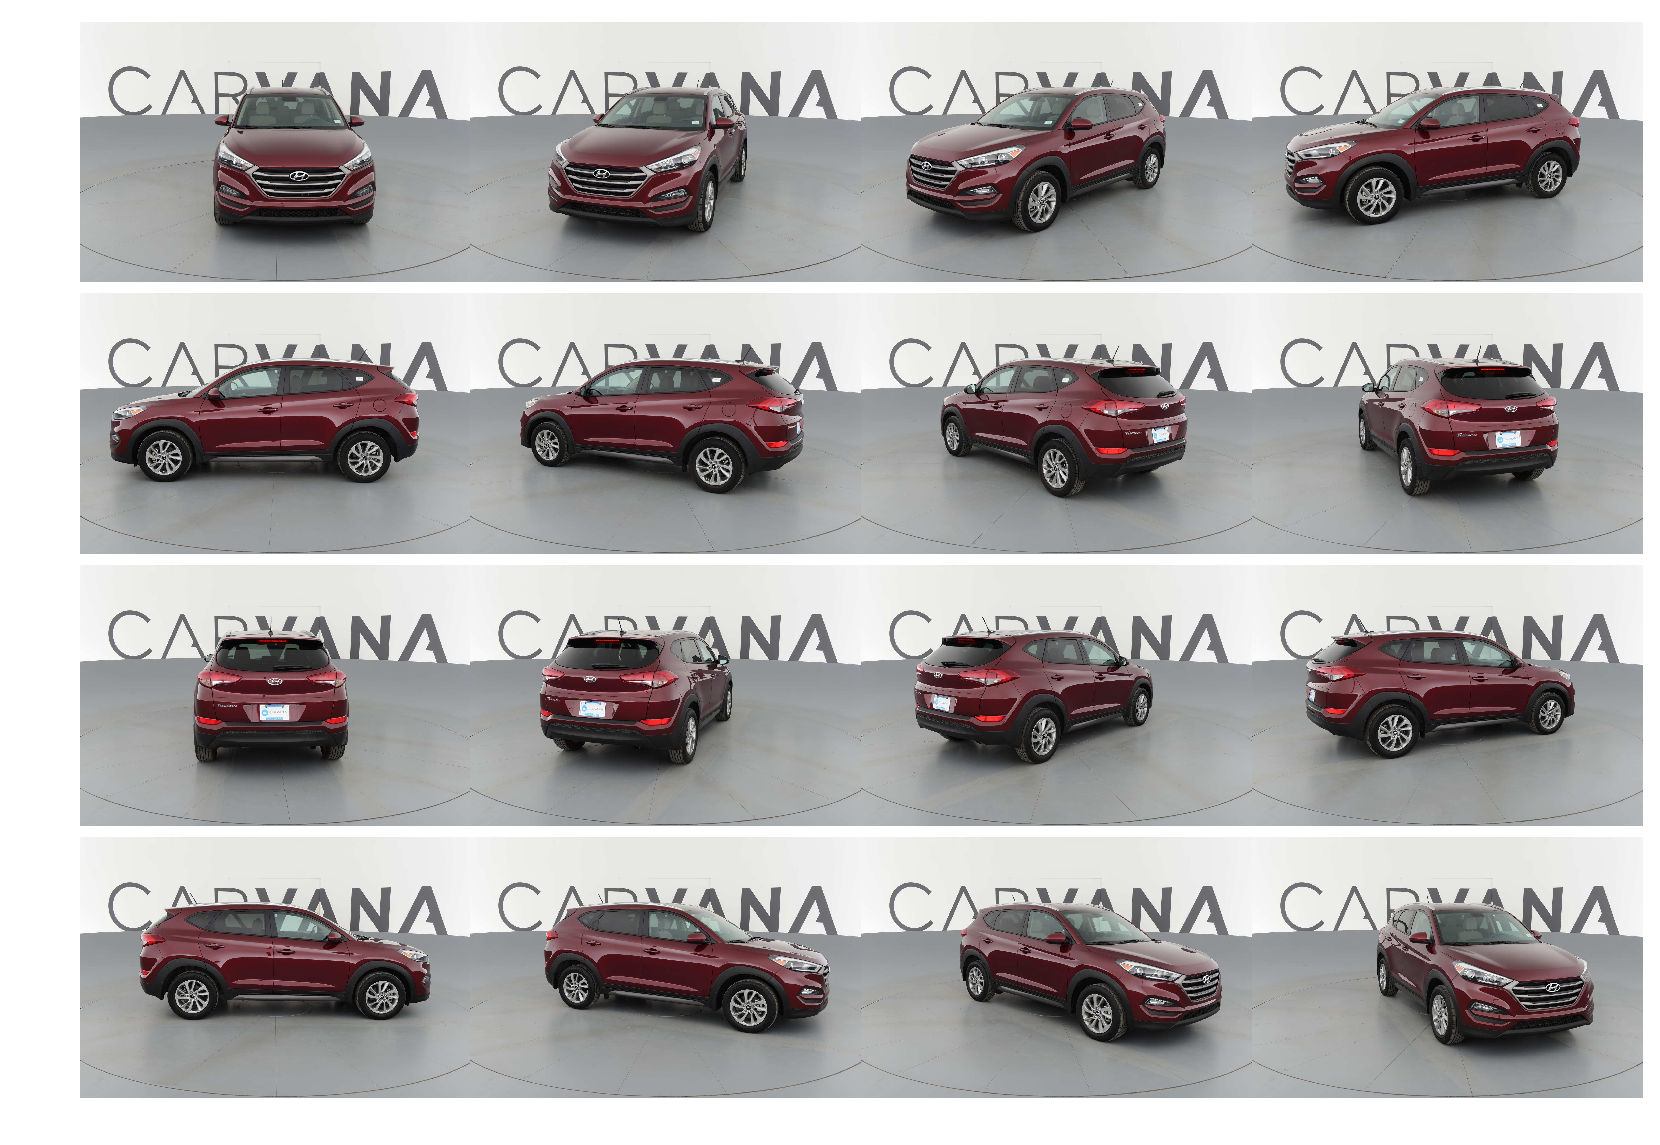

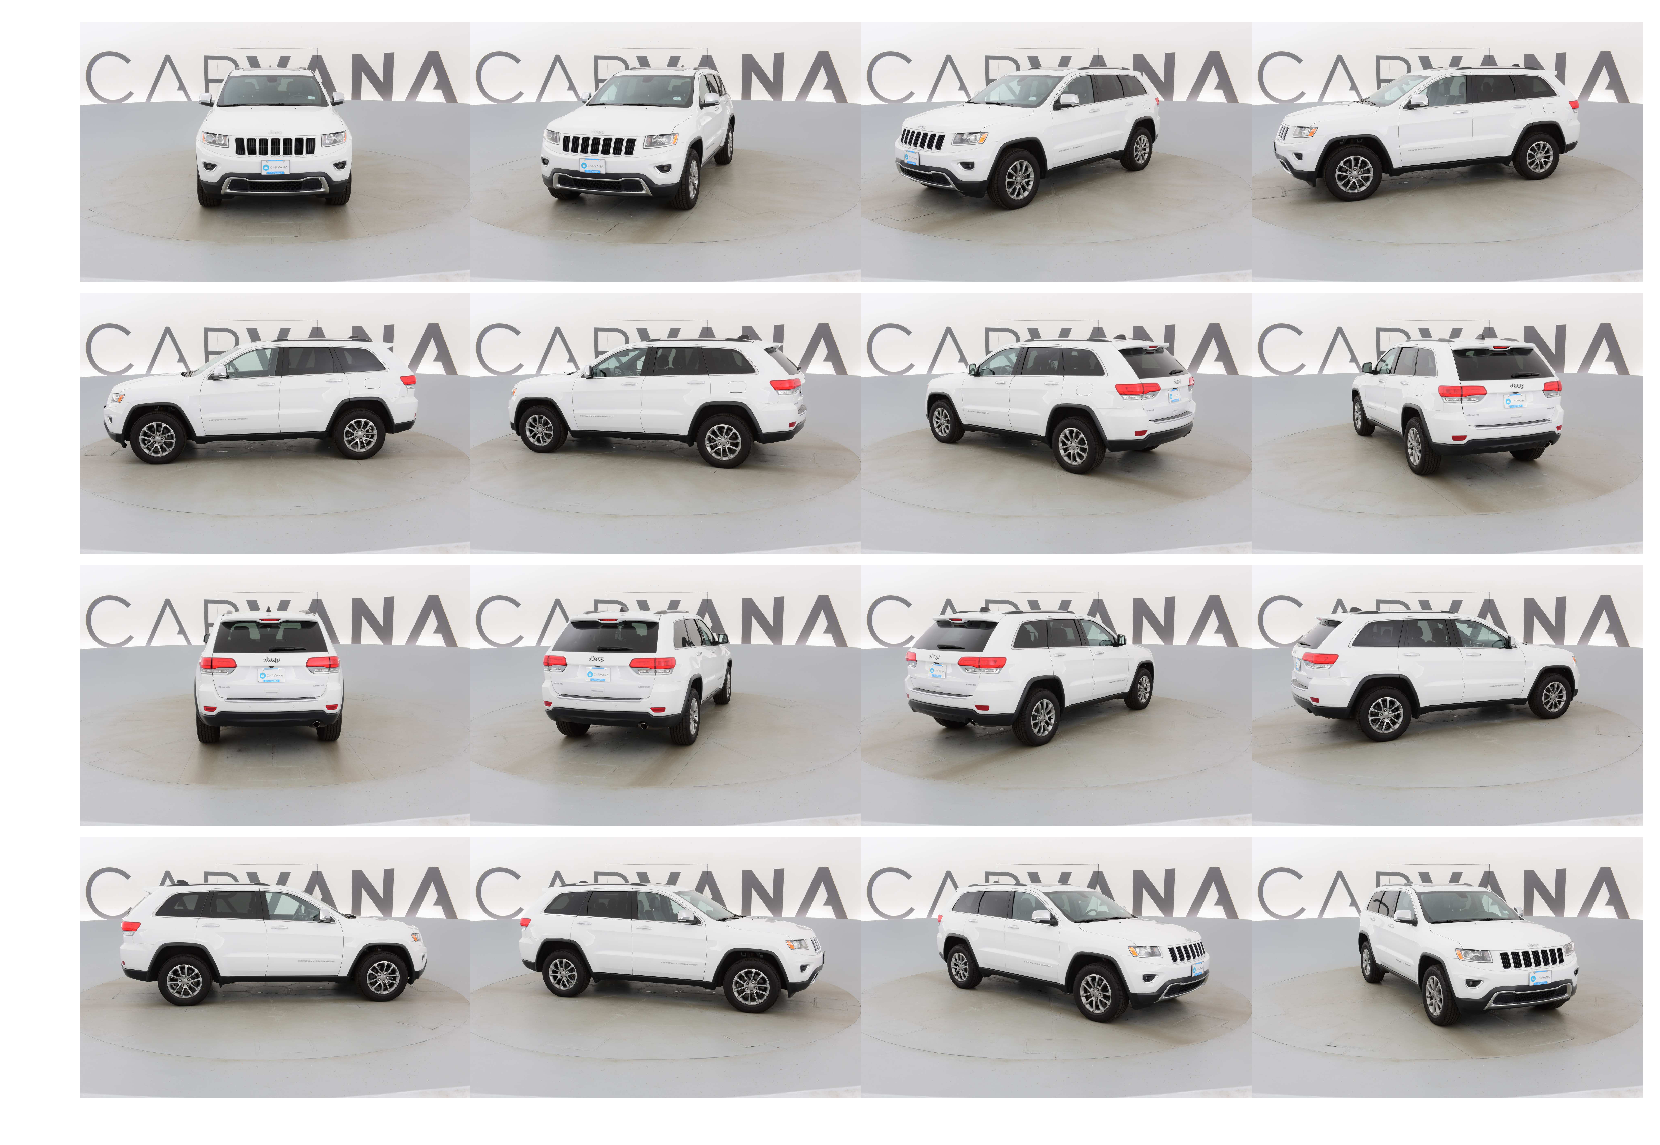

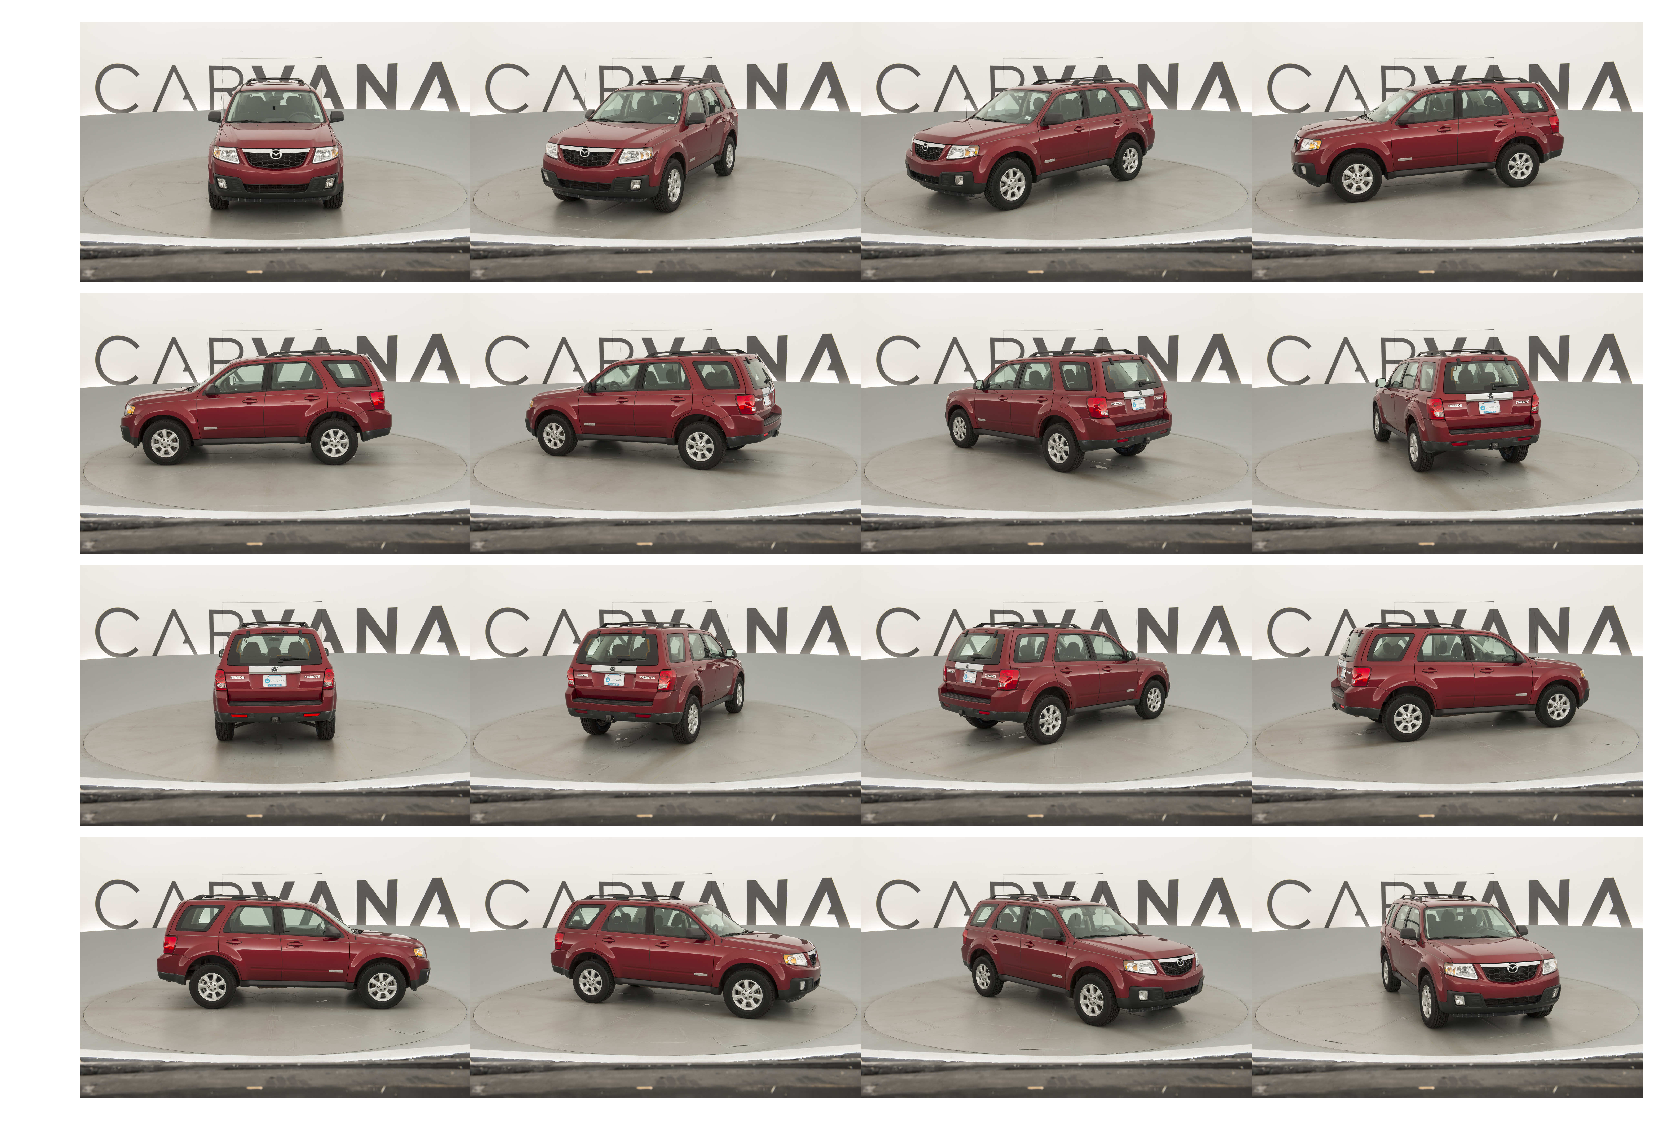

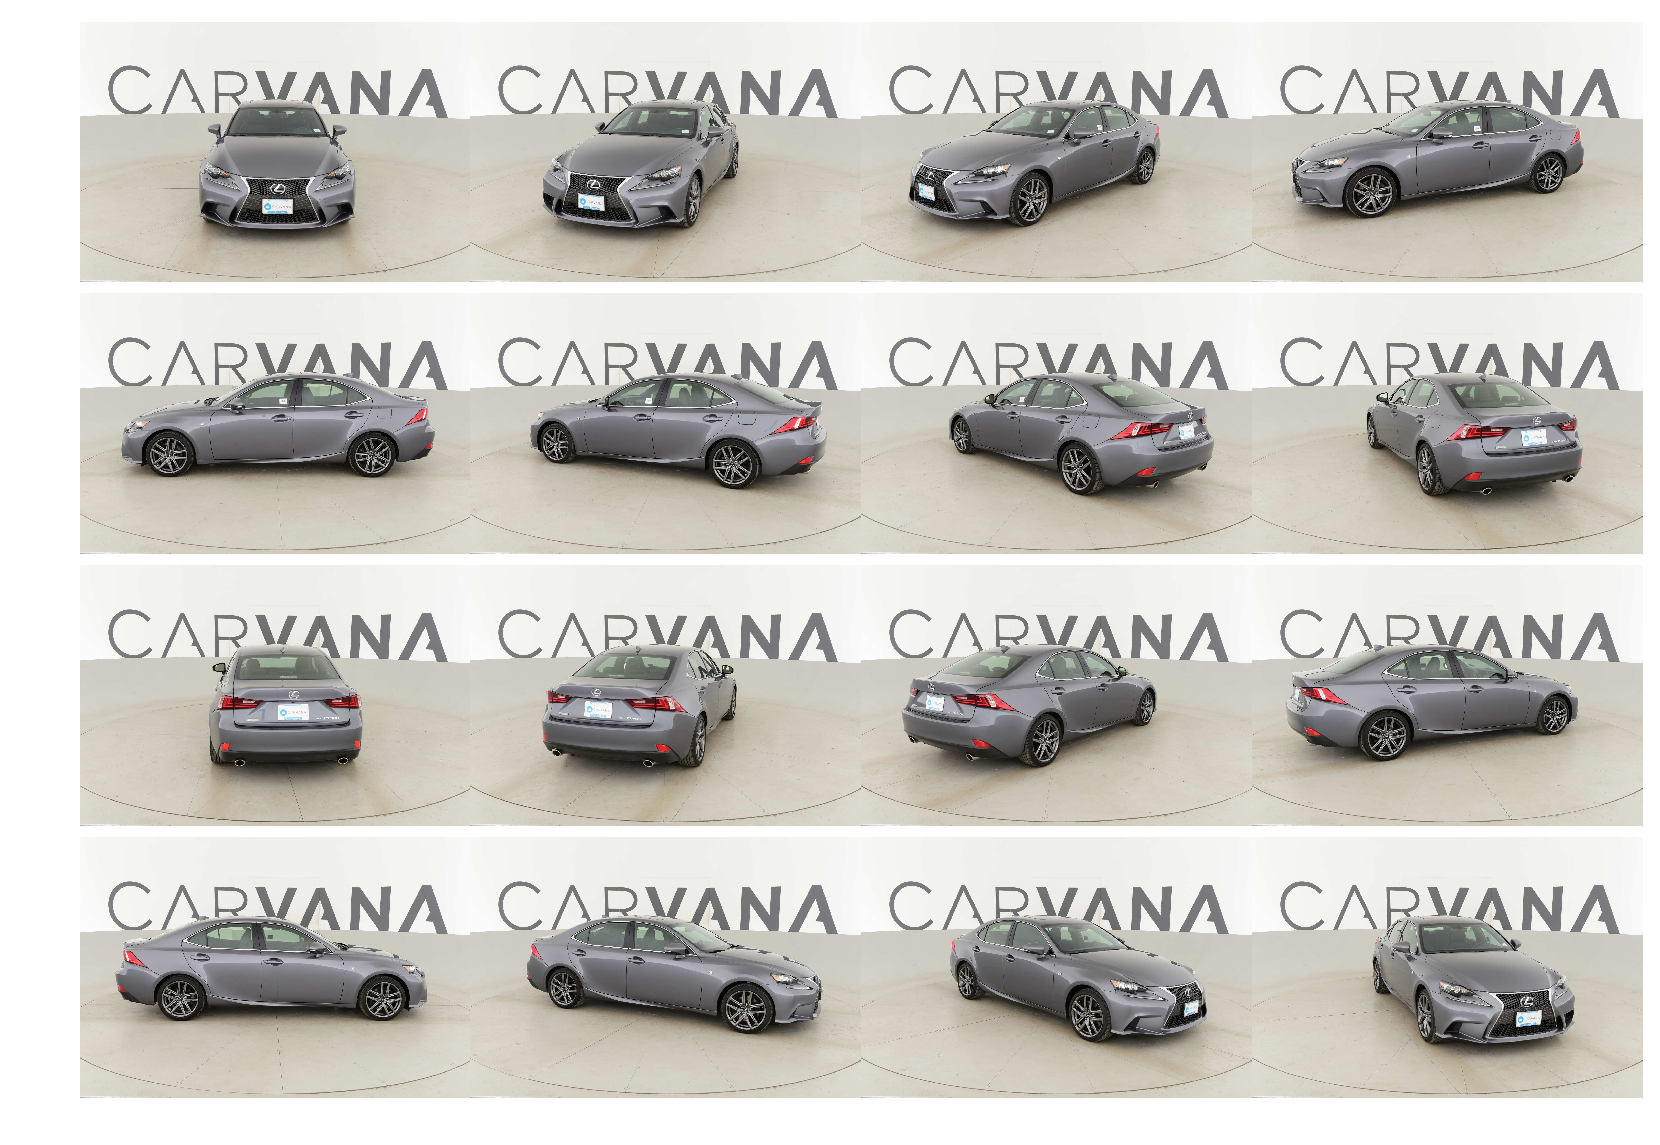

In [12]:
images_path = [get_car_image_files(id) for id in train_ids[:5]]

for i, angles in enumerate(images_path):
    _, axs = plt.subplots(4, 4, figsize=(14, 10))  #  figsize=(20, 20)
    plt.rc('axes', grid=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    axs = axs.ravel()
    
    for j, img_path in enumerate(angles):
        img = mpimg.imread(img_path)
        axs[j].axis('off')
        axs[j].imshow(img);

## How many different cars in the dataset

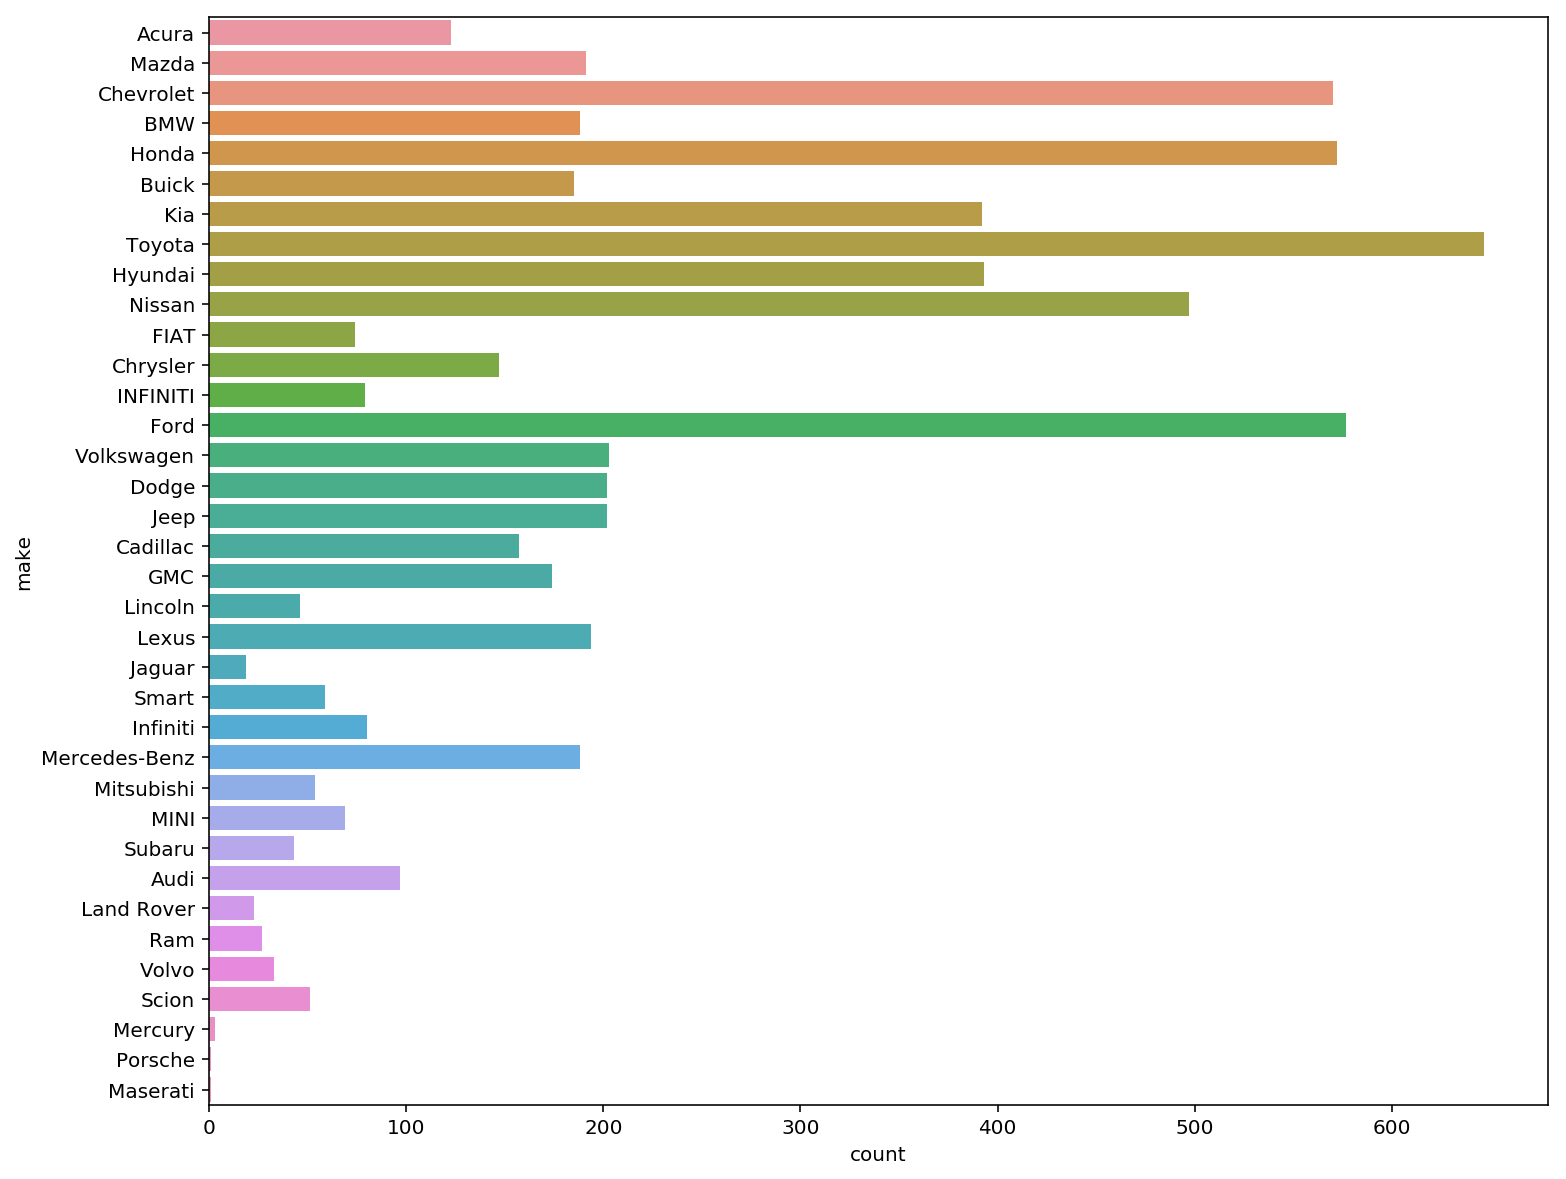

In [13]:
plt.figure(figsize=(12, 10))
sns.countplot(y="make", data=metadata_df);